
# Conflicts and versions 

Conflicts are essential part of any distributed system. 
Conflict arise when there exist two versions of the same message both of them being valid.

As we've seen from the previous notebooks, network can be unreliable: peer might receive the message with a long delay. But what about faults/conflict from the clients/message producers? Moreover, a message might have multiple valid versions.  It could be that peers received two versions of the message, both being perfectly signed and valid. What version to choose? What to do when an order of the message is important? 




In [1]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper


## Client generating conflicting information

Let's assign first byzantine nodes, we will assign randomly: 

In [2]:
import random
import string

from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class Transaction(BaseMessage):
    pass 

class ConflictMessageProducer(MessageProducer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.counter), str(self.peer.peer_id)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        # Store only the last version
        self.peer.store('msg_time', str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(peer_services['client'].service_map['MessageProducer']):
    pre_task = Func(validate_task)
    
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService

TypeError: NoneType takes no arguments

## Run simulation 

Let's see how byzantine agents together with crashing nodes affect the message dissemination. 

In [3]:
peer_services

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'MessageProducer': <class '__main__.MsgConfig'>}),
 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RandomDowntime': <class 'p2psimpy.config.DowntimeConfig'>, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>})}

In [5]:
# Init Graph
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(5_200)

## Message analysis

Let's see how this fraction of byzantine nodes affected the network. 



In [6]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        msg_num, client_id = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,False,False,False,True,False,True,True,False,False,True,...,False,False,False,True,True,False,False,False,False,True
2,False,True,True,False,True,True,False,False,True,True,...,False,True,False,False,True,True,False,False,False,True
3,False,True,True,True,False,True,True,False,True,True,...,False,True,True,False,True,True,False,False,False,True
4,False,True,True,True,True,False,True,False,True,True,...,True,True,False,False,True,False,False,False,False,False
5,False,True,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
6,False,True,True,True,False,True,True,False,False,True,...,False,True,True,True,True,True,True,True,False,True
7,False,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,False,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,True,True,True,True,False,True,True,...,True,False,False,True,True,True,False,True,True,False
10,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False


In [7]:
df[df==False].count()

1     20
2      9
3      9
4      3
5     14
6      8
7      8
8     17
9      8
10     2
11    10
12    10
13    15
14     0
15    11
16    13
17    11
18    10
19    14
20     2
21    11
22    13
23    11
24    17
25    10
dtype: int64

In [8]:
sim.peers[1].storage['msg_data'].txs

{'1_26': GossipMessage:Transaction:{'hash': 'QNLLEXAQKAJTFDCOIDLA', 'balance': 96, 'diff': 4},
 '2_26': GossipMessage:Transaction:{'hash': 'KESJQWRBUOOYBVMREPET', 'balance': 87, 'diff': 6},
 '3_26': GossipMessage:Transaction:{'hash': 'ZEGWHPCQNEXTVMGOSGFP', 'balance': 79, 'diff': 7},
 '4_26': GossipMessage:Transaction:{'hash': 'UIZDUAPGXCPBKUUIYELY', 'balance': 79, 'diff': 6},
 '5_26': GossipMessage:Transaction:{'hash': 'ZYVIAECYWLUKTJAIFXHD', 'balance': 68, 'diff': 8},
 '6_26': GossipMessage:Transaction:{'hash': 'XPYMFHJEMPVEVBGXWQAP', 'balance': 65, 'diff': 4},
 '7_26': GossipMessage:Transaction:{'hash': 'AEPRCVBXDPXDOAISZDVM', 'balance': 60, 'diff': 5},
 '9_26': GossipMessage:Transaction:{'hash': 'IUHRCYIFGEUPTNQMFMAS', 'balance': 43, 'diff': 9},
 '10_26': GossipMessage:Transaction:{'hash': 'LHGLFIVNFVINITJDIQBA', 'balance': 48, 'diff': 1},
 '8_26': GossipMessage:Transaction:{'hash': 'DPTPELOFYCLVTXPYRCKL', 'balance': 57, 'diff': 1},
 '11_26': GossipMessage:Transaction:{'hash': 'MDL

In [9]:
sim.peers[3].storage['msg_data'].txs

{'1_26': GossipMessage:Transaction:{'hash': 'QNLLEXAQKAJTFDCOIDLA', 'balance': 96, 'diff': 4},
 '2_26': GossipMessage:Transaction:{'hash': 'SOHNTYXFJAJJJRIDUPKL', 'balance': 86, 'diff': 7},
 '3_26': GossipMessage:Transaction:{'hash': 'RNONGWDVQFQPTSSTTZZU', 'balance': 85, 'diff': 1},
 '4_26': GossipMessage:Transaction:{'hash': 'VNEJIFAVWPVOSYLFRACL', 'balance': 76, 'diff': 9},
 '5_26': GossipMessage:Transaction:{'hash': 'ZYVIAECYWLUKTJAIFXHD', 'balance': 68, 'diff': 8},
 '6_26': GossipMessage:Transaction:{'hash': 'WZAUXZAZSKSZJGKLHWJU', 'balance': 65, 'diff': 4},
 '7_26': GossipMessage:Transaction:{'hash': 'SMHEZEXBZOFXMCGQERIK', 'balance': 58, 'diff': 7},
 '8_26': GossipMessage:Transaction:{'hash': 'DPTPELOFYCLVTXPYRCKL', 'balance': 57, 'diff': 1},
 '9_26': GossipMessage:Transaction:{'hash': 'IUHRCYIFGEUPTNQMFMAS', 'balance': 43, 'diff': 9},
 '10_26': GossipMessage:Transaction:{'hash': 'LHGLFIVNFVINITJDIQBA', 'balance': 48, 'diff': 1},
 '11_26': GossipMessage:Transaction:{'hash': 'PFB

Peers see different versions of the same message. This is an issue as it might violate integrity guarantees. For example, peers might have different view on the client's balance. 

How to fix this? In short - *consensus*.


# Consensus 


Consensus is a process that allows to achieve consistent view on a value (agreement). 
Some of the peers may fail or be unreliable, so consensus protocols must be fault tolerant or resilient. The peers must communicate with one another, and agree on a single consensus value.

The consensus problem is a fundamental problem in any distributed systems. One approach to generating consensus is for all processes (agents) to agree on a majority value. In this context, a majority requires at least one more than half of available votes (where each process is given a vote). However, one or more faulty processes may skew the resultant outcome such that consensus may not be reached or reached incorrectly.


## Majority voting consensus 

Typically, this consensus family chooses a leader. This leader collects votes from other peers and decides on the canonical value based on the majority. All other peer reject alternative versions. One of the famous example of this family is PBFT. 
Modern versions and variations of this family include Hyperledger Fabric, Quorum, Tendermint etc.

### Simulate leader voting collection

TBA.

### Advantages/ Disadvantages 


TBA.

## Consensus through a Lottery

Nakamoto consensus - run a lottery to choose 

TBA


## Simulation

Peers are exchanging transactions and recording 


In [11]:
from p2psimpy.services import BaseRunner, BaseHandler
from p2psimpy import BaseMessage, GossipMessage, MsgResponse, Cache
from p2psimpy.storage import DagStorage, RangedStorage  
from itertools import islice
from p2psimpy.utils import to_hash

class Block(BaseMessage):
    
    base_size = 100 # 
    
    def __init__(self, sender, block_id, prev_id, txs):        
        super().__init__(sender, data=txs)
        self.id = block_id
        self.prev_id = prev_id

class Consensus(BaseRunner, BaseHandler):
    """
    Consensus based on blocks and longest-chain rule.
    Args:
        mining_time: DistAttr, Dist or value to indicate time for a mining process. 
        conf_num: number of confirmation when transaction is considered final.
        max_txs_per_block: maximum number of transaction per block.
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.mining_time = Cache(kwargs.pop('mining_time', Dist('norm', (1500, 300))))
        self.conf_num = kwargs.pop('conf_num', 6)
        self.max_txs_per_block = kwargs.pop('max_txs_per_block', 100)
        
        self.init_ttl = kwargs.pop('init_ttl', 3)
        self.init_fanout = kwargs.pop('init_fanout', 6)
        self.pre_task = kwargs.pop('pre_task', None)
        self.post_task = kwargs.pop('post_task', None)
        self.exclude_types = kwargs.pop('exclude_types', {'bootstrap', 'client'})
        
        
        # Working transaction pool
        self.tx_pool = set()
        
        # initialize storage for the map: tx_id: number of confirmations 
        self.peer.add_storage('txs_conf', RangedStorage())
        self.main_strg = self.peer.storage.get('txs_conf')
        
        # Storage for blocks
        self.peer.add_storage('blocks', DagStorage())
        self.blocks = self.peer.storage.get('blocks')
        
        # Add genesis block
        self.blocks.add(0, 'Genesis', [])
        
    def _handle_gossip_msg(self, msg):
        if isinstance(msg.data, Transaction):
            tx_conf = self.main_strg.get(msg.data)
            if not tx_conf or tx_conf <= self.conf_num:
                # add to transaction pool as either new, or potentially unconfirmed
                self.tx_pool.add(msg.data)
        elif isinstance(msg.data, Block):
            block = msg.data
            # Add block to the block storage
            self.blocks.add(block.id, block.prev_id, block.data)
        
    
    def handle_message(self, msg):
        if isinstance(msg, MsgResponse):
            for msg_id, sub_msg in msg.data.items():
                self._handle_gossip_msg(sub_msg)
        else:
            self._handle_gossip_msg(msg)
            
    @property
    def messages(self):
        return GossipMessage, MsgResponse,
    
    def validate_chain(self, chain):
        """
        Validation rules for the chain:
         - Transaction in the chain are unique 
        Returns:
            None if chain is not valid, transactions set otherwise             
        """
        full_tx_set = {'0': 1}
        block_conf = 1
        for c,p in zip(*(islice(chain, i, None) for i in range(2))):
            for tx in self.blocks.get(c).get(p)['data']:
                # validate transaction: it must be unique 
                if tx in full_tx_set:
                    # Transaction was already seen in the chain! 
                    # Double transaction detected - Invalidate the chain
                    return None
                else:
                    full_tx_set[tx.data['hash']] = block_conf
            block_conf+=1
        return full_tx_set
    
    def choose_parent_block(self):
        """
        Returns:
            Block id of the last block in the longest valid chain.
        """
        for chain in self.blocks.get_longest_chains():
            tx_set = self.validate_chain(chain)           
            if tx_set:
                # add tx_set to the working db
                self.main_strg.clear_all()
                self.main_strg.batch_add(tx_set)
                return chain[0]

    def choose_transactions_from_pool(self):
        to_remove = set()
        new_txs = set()
        for tx in self.tx_pool:
            tx_conf = self.main_strg.get(tx.data['hash'])
            if not tx_conf:
                new_txs.add(tx)
            elif tx_conf > self.conf_num:
                to_remove.add(tx)
        self.tx_pool-=to_remove
        
        # From the new transaction choose transaction based on some criteria
        # Take transactions until you hit max_size
        
        # For now we will just limit by the number of transactions
        return list(new_txs)[:self.max_txs_per_block]
    
    def produce_block(self, block_id, prev_id, data):
        """
        Creates a block message and gossips to the neighbors 
        """
        # Create block message 
        block = Block(self.peer, block_id, prev_id, data)  
        # Wrap around GossipMessage 
        msg_id = 'b_'+str(block_id)
        msg = GossipMessage(self.peer, msg_id, block, self.init_ttl,
                            pre_task=self.pre_task, post_task=self.post_task)
        # Add block to the local chain storage
        self.blocks.add(block_id, prev_id, data)
        # Store msg for the further gossip
        self.peer.store('msg_time', msg_id, self.peer.env.now)
        self.peer.store('msg_data', msg_id, msg)
        # Gossip to the network
        self.peer.gossip(msg, 
                         self.init_fanout, except_type=self.exclude_types)
                
    def run(self):
        while True:
            # Choose last id of the block
            last_id = self.choose_parent_block()
            # Choose unproccessed transactions from the tx_pool 
            new_txs = self.choose_transactions_from_pool()
            # Calculate block id with these transactions (Mining Process)
            yield self.env.timeout( self.mining_time())        
            block_id =  to_hash(str(last_id) + str(new_txs))
            if new_txs:
                self.produce_block(block_id, last_id, new_txs)


In [12]:
# Add consensus to the known services
peer_services['peer'].service_map[Consensus] = None


In [13]:
%%time
sim2 = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim2.run(20_200)

CPU times: user 3.11 s, sys: 8.17 ms, total: 3.12 s
Wall time: 3.11 s


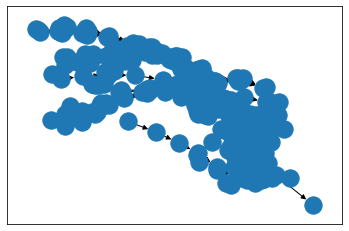

In [14]:
nx.draw_networkx(sim2.peers[1].storage['blocks'].dag, with_labels=False)

In [15]:
sim2.peers[5].storage['txs_conf'].txs

{'0': 1,
 'TEQCTIKKKZSURRETOYBN': 1,
 'ENBTIQYESIZEZRDMKIGD': 1,
 'MLOXBXVJCECEPKGSHEYT': 1,
 'DBDMZWMNRXAQPFKVVQSN': 1,
 'SVNNJLGJLVFHNXAZLCXJ': 1,
 'VOJSCNQVUIWONGCYCBRK': 1,
 'DZUNRJWIKBXXIOWDJEOF': 1,
 'SHTBQAYBIPIVAQUZCPIC': 1,
 'QCOEUQLNAARZCZODEXIE': 1,
 'MONZECAUJCGIKWVLXRSR': 1,
 'UOMDVHBYOLPFZMDTOTYY': 1,
 'IYJWJHCZCKJUNNSETCLV': 1,
 'PTRBRCHOFSZKEEFASLEB': 1,
 'MPJMYOAEOELCDCGFXTID': 1,
 'YUXJYGIWPJUYCZCIRQOF': 1,
 'LSXIBPQAKUDFGWVMBAHH': 1,
 'KZBFZCJXPNHBACKNKUIN': 2,
 'RIUGXZZZCVCATCHCQTBO': 2,
 'GMWLZFFYPYHAMWKHTAWW': 2,
 'JXMQFIZHTJMOZQNGKZMD': 2,
 'UEWIJRGJHFKHFHRIROBT': 2,
 'HQAWUOLGYINLRQQKLRYH': 2,
 'YXVEORNIQJORYOCGBVIF': 2,
 'AIZLWYNSQTQEKKIGUJJE': 3,
 'QEHXMIAIWHLFUQMEGNEA': 3,
 'WXMHTNEJZURYHGROWFCP': 3,
 'SJMVWRGWNPFWWBJCKOLA': 3,
 'YIMMGTVGVFARQGPUWGSC': 3,
 'LXMFSSXRRWLDDGJWKKTE': 3,
 'WZERMIYPCESPOVZMCHRI': 3,
 'XRTLHHHXRNSOYVARNIHA': 3,
 'ISMMJMHERGQPDGCBISPR': 3,
 'VMFXVTGVDVREHIMTBXYY': 3,
 'IGKITNZOQZVOQHXYPKAC': 3,
 'BYXQQGMYOXQRYHTTAMYJ': 4,
 'PRMURRSZO

In [16]:
sim2.peers[23].storage['txs_conf'].txs

{'0': 1,
 'TEQCTIKKKZSURRETOYBN': 1,
 'CLVLNWMBBVYJZAOBTZZM': 1,
 'KZBFZCJXPNHBACKNKUIN': 1,
 'UEWIJRGJHFKHFHRIROBT': 1,
 'PTRBRCHOFSZKEEFASLEB': 1,
 'LSXIBPQAKUDFGWVMBAHH': 1,
 'SJMVWRGWNPFWWBJCKOLA': 2,
 'RIUGXZZZCVCATCHCQTBO': 2,
 'XRTLHHHXRNSOYVARNIHA': 2,
 'GMWLZFFYPYHAMWKHTAWW': 2,
 'AIZLWYNSQTQEKKIGUJJE': 3,
 'YIMMGTVGVFARQGPUWGSC': 3,
 'WZERMIYPCESPOVZMCHRI': 3,
 'LXMFSSXRRWLDDGJWKKTE': 3,
 'NPZWCTJRYLQLZQQQDGRD': 3,
 'ISMMJMHERGQPDGCBISPR': 3,
 'PZNTRROZODHNXJCOOTGK': 4,
 'HFUGENHMIOURXGXQOJWL': 4,
 'AWEXPYVEQZHEWMJKTEQE': 4,
 'VGVGEMFTUGXNRUATTMYO': 4,
 'QUZODHZGSBYGFCFNIPFS': 4,
 'YKTBXPIZMOHHZPRZXLSB': 4,
 'BIKQLDRMSBKOVCZIMVXS': 5,
 'IZRCFBSJAQKAWSGKQMSX': 5,
 'AVABBOPPONXNHEZVRPZK': 5,
 'MUVDPGYGPTFPDXLWWLKG': 5,
 'VSPMJHVBLYRSZRYZITIL': 5,
 'BPLZTNQXBPMGGKVERBBN': 5,
 'WMCRCIRWHKLISVFSUASN': 5,
 'SVHQVUOTSECCJKOEJWSF': 5,
 'CHBJOTVFKILXIJJQZZXW': 5,
 'YQFAKJINCTFFMTRGUDBU': 5,
 'YNKAVHPOHIDWIUGBDOHT': 5,
 'XCXUBXDURSJFDTNJJIRY': 5,
 'DMVSWYTQPMUPQRAJSJEK': 5,
 'ASCSTOLKA